In [1]:
## Need to run this notebook using a python3.8 kernel (install with venv) for retro to work properly

In [76]:
#%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/aremath/p38-env/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['get_state', 'f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [77]:
# Gross
import sys
sys.path.append("..")

In [78]:
import retro
import gzip

In [79]:
from abstraction_validation.abstractify import *
from world_rando.coord import Coord
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import functools
import imageio
import IPython.display
from abstraction_validation.go_explore import *

In [80]:
from world_rando import parse_rules

In [81]:
from world_rando import model_checking
from pathlib import Path

In [82]:
import networkx as nx
import pickle

In [83]:
from rom_tools.rom_manager import RomManager

In [84]:
rom = RomManager("../../roms/sm_clean.smc", "../../roms/sm_whatever.smc")
obj_names = rom.parse()

In [85]:
def room_image(ptr):
    room_header = obj_names[f"room_header_{ptr}"]
    l = parse_rules.make_level_from_room(room_header)
    return l, l.to_image()

In [86]:
gauntlet_level, gauntlet_image = room_image("0x7965b")
print(type(gauntlet_level))
gauntlet_image

0xb703
0xeed7
<class 'world_rando.rules.LevelState'>


In [87]:
rules, tests = parse_rules.parse_rules(["../encoding/rules/rules.yaml",
                                        "../encoding/rules/model_checking_tests/model_checking_tests.yaml"])

In [88]:
i_state, final_state = tests["ConstructionZone"]
#i_state, final_state = tests["ModifiedConstructionZone2"]
initial_state = i_state.samus
level = i_state.level
initial_states, k = model_checking.make_kripke(initial_state, final_state, level, rules.values())

Search to reach None from c(23,9)
Applied 3323 rules
Enumerated 3322 states in 3.3071687999999995 seconds


100%|█████████████████████████████████████████████████████████████████████████████| 3322/3322 [00:02<00:00, 1119.74it/s]


Number of States: 3322
Built graph with 13904 edges in 3.078420499999993 seconds


In [89]:
# Create forward + backward graph
G = nx.Graph()
G2 = nx.Graph()
for (n1, n2) in k.edges_iter():
  G.add_edge(n1, n2)
  G2.add_edge(n2, n1)

In [90]:
def get_distances(G, state):
  distances = {state: 0}
  for (v, u) in nx.algorithms.traversal.bfs_predecessors(G, state):
    distances[v] = distances[u] + 1
  return distances

In [91]:
source_distances = get_distances(G, initial_state)
#TODO this is a hack!
final_state = list(k.states())[-1]
final_distances = get_distances(G2, final_state)
shared_distances = {k: source_distances[k] + final_distances[k] for k in source_distances.keys()}
shortest_path_distance = min(shared_distances.values())

In [92]:
retro.__version__

'0.8.0'

In [93]:
print(retro.__path__)

['/home/aremath/p38-env/lib/python3.8/site-packages/retro']


In [95]:
del emu

In [96]:
emu = retro.RetroEmulator("../../roms/supermetroid.sfc")
gamedata = retro.data.GameData()
emu.configure_data(gamedata)

In [97]:
def get_state(filename):
  with gzip.open(filename, "rb") as f:
    return f.read()

In [99]:
#back_of_gauntlet = get_state("../abstraction_validation/back_of_gauntlet.state")
#emu.set_state(back_of_gauntlet)
#emu.step()
#matshow(emu.get_screen())
#emu.step()
#matshow(emu.get_screen())

In [62]:
blue_brinstar_elevator = get_state("../abstraction_validation/blue_brinstar_elevator.state")
emu.set_state(blue_brinstar_elevator)
emu.step()

In [67]:
#movie = retro.Movie("../abstraction_validation/blue_brinstar.bk2")
movie = retro.Movie("../abstraction_validation/ayy.bk2")
movie_start = movie.get_state()
emu.set_state(movie_start)
emu.step()
frames = []
rams = []
special_rams = []
inputs = []
while movie.step():
    keys = []
    for i in range(12):
      keys.append(movie.get_key(i, 0))
    inputs.append(tuple(keys))
    frames.append(emu.get_screen())
    rams.append(np.frombuffer(gamedata.memory.blocks[0x7e0000],'uint8'))
    special_rams.append(frombuffer(gamedata.memory.blocks[0], dtype=np.uint8))
    emu.set_button_mask(keys,0)
    emu.step()
rams = array(rams)

RuntimeError: Could not load movie

In [54]:
# region + map + area
# Where is the test model we are using relative to the actual (global) position area? 
offset = Coord(64, 32) + Coord(336, 128) + Coord(0, 464)

In [55]:
model_states = list(k.states())
slop = 4
good_model_states = [s for s in model_states if shared_distances[s] <= shortest_path_distance + slop]
cell_ok = mk_cell_ok(good_model_states, 2, offset)

In [56]:
cell_dist = mk_cell_dists(good_model_states, final_distances, offset)
cell_dist_selector = SoftminSelector(cell_dist)

In [58]:
def morph_goal(abstract_state):
    return "MB" in abstract_state.items

In [123]:
# Try to get morph ball with heuristic guidance
atlas, graph, _, _ = go_explore(blue_brinstar_elevator, list(set(inputs)), emu, gamedata, 8000, 20, cell_ok=cell_ok, goal=morph_goal, cell_selector=cell_dist_selector, global_pos=True, seed=7)

(c(423,633)|V: 0, H: RUN, 0|STAND|ISet([]))


 10%|███████▉                                                                      | 816/8000 [00:10<01:29, 80.22step/s]


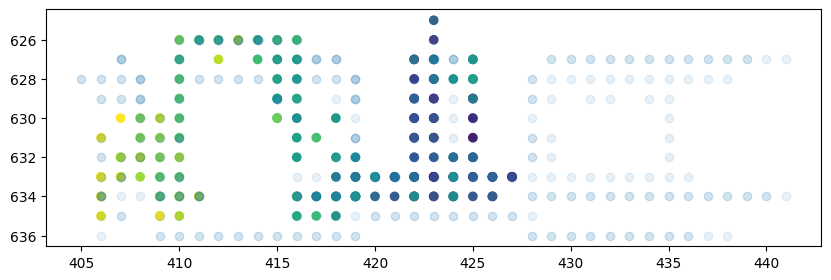

In [124]:
good_model_positions = [s.position + offset for s in good_model_states]
figure(figsize=(10,10))
#TODO: the colors are wrong because of stacking
scatter(*np.array([a.position for a in atlas.keys()]).T, c=arange(len(atlas.keys())), cmap="viridis")
scatter(*array(good_model_positions).T, alpha=0.1)
#scatter(*array(model_positions).T, alpha=0.1)
gca().set_aspect("equal")
gca().invert_yaxis()

In [125]:
n=list(graph.nodes())[0]
graph.nodes[n]["ram"]

array([-25133,      0, -19190, ...,  21845,  21845,  21845], dtype=int16)

In [126]:
def score(node):
    ram = graph.nodes[node]["ram"]
    s = abstractify_state(ram)
    return "MB" in s.items

source = list(graph.nodes)[0]
target = max(graph.nodes, key=score)
p = nx.shortest_path(graph, source, target)

Length: 37 states, 464 frames


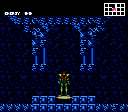

In [127]:
resim_and_write(emu, p, graph, fname="output/sm.gif", framespeed=4, imscale=2)
IPython.display.Image(filename="output/sm.gif")

In [129]:
len(blue_brinstar_elevator)
type(blue_brinstar_elevator)

bytes

In [165]:
# Find the ram inside of a state

In [13]:
import re

In [14]:
candidates = list([m.start() - 0x079B for m in re.finditer(b"\x9f\x9e", blue_brinstar_elevator)])
candidates2 = list([m.start() - 0x07B5 for m in re.finditer(b"\xe5\x9e", blue_brinstar_elevator)])
candidates3 = list([m.start() - 0x07a1 for m in re.finditer(b"\x15\x00\x08\x00", blue_brinstar_elevator)])
print(candidates)
print(candidates2)
print(candidates3)

[22775, 68502]
[68502, 380266]
[68502]


In [15]:
ram_offset = 68502

In [16]:
# Should be 0x15
map_x = int.from_bytes(blue_brinstar_elevator[ram_offset + 0x07a1: ram_offset + 0x07a3], byteorder="little")
# Should be 0x8
map_y = int.from_bytes(blue_brinstar_elevator[ram_offset + 0x07a3: ram_offset + 0x07a5], byteorder="little")
print(map_x, map_y)
#$07A5: Room width in blocks
map_x = int.from_bytes(blue_brinstar_elevator[ram_offset + 0x07a5: ram_offset + 0x07a7], byteorder="little")
#$07A7: Room height in blocks
map_y = int.from_bytes(blue_brinstar_elevator[ram_offset + 0x07a7: ram_offset + 0x07a9], byteorder="little")
print(map_x, map_y)

21 8
128 48


In [44]:
# Test out our newfound powers
print(len(blue_brinstar_elevator))
blue_a = bytearray(blue_brinstar_elevator)
blue_m = memoryview(blue_a)
blue_hp_change = np.frombuffer(blue_m[ram_offset:-1], dtype="<i2") # Bytes immutable, so make a copy
# Alter samus health
hp_offset = 0x09C2
#print(int.from_bytes(blue_brinstar_elevator[ram_offset + hp_offset: ram_offset + hp_offset + 2], byteorder="little"))
#new_health_bytes = int.to_bytes(49, 2, byteorder="little")
#blue_brinstar_elevator2a[ram_offset + hp_offset: ram_offset + hp_offset + 2] = new_health_bytes
blue_hp_change[hp_offset // 2] = 42
print(blue_hp_change[hp_offset // 2])
blue2 = bytes(blue_a)

430181
42


In [45]:
int.from_bytes(blue2[ram_offset + hp_offset: ram_offset + hp_offset + 2], byteorder="little")
int.from_bytes(blue_a[ram_offset + hp_offset: ram_offset + hp_offset + 2], byteorder="little")

42

In [34]:
emu.set_state(blue2)
emu.step()
# Apparently it takes 2 steps for the HUD to update to the new value...
emu.step()
matshow(emu.get_screen())

NameError: name 'matshow' is not defined